## Imports and Cleaning

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from data_clean import *
from viz_helper import *
%load_ext autoreload
%autoreload 10

### Live data
For this project, data is read in live from Johns Hopkins CSSE, the New York Times, and the Covid Tracking Project (associated with The Atlantic). The update times for each source differ across the sources, but are typically fully updated by the next day. 
Their sources, on the other hand, are from a collection of government agencies for international cases, and often state health department websites for county and state level information. The COVID Tracking Project provides a grade for each state depending on the reliability of testing data: https://covidtracking.com/about-data.
For quick dashboards, check out the Hopkins CSSE dash: https://coronavirus.jhu.edu/map.html.


In [3]:
# Countries from Johns Hopkins, State & Local from NYT, and Testing from the Covid Tracking Project
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [4]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log

/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



In [5]:
testing = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')
df_testing = clean_data_trackingproject(testing)

In [6]:
# Quick list of dates when US states entered into some form of containment or lockdown
containment = pd.read_csv('containment.txt')
containment.columns = ['State', 'Date']
containment = containment.sort_values(by='Date').groupby(by='State').agg('last').reset_index()
containment.sample(5)

,State,Date
3,California,2020-03-19
5,Connecticut,2020-03-24
19,Massachusetts,2020-03-24
20,Michigan,2020-03-24
4,Colorado,2020-03-26


In [7]:
# us_census = pd.read_csv("../input/us-census-demographic-data/acs2017_county_data.csv")
# state_abbr = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")

In [8]:
df_country[df_country.Country.isin(['US'])].tail()

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
13787,US,2020-04-05,337072,2020-01-24,73,28219.0,4.290459,12.728052,10.247751
13971,US,2020-04-06,366667,2020-01-24,74,29595.0,4.304065,12.812209,10.295361
14155,US,2020-04-07,396223,2020-01-24,75,29556.0,4.317488,12.889732,10.294042
14339,US,2020-04-08,429052,2020-01-24,76,32829.0,4.330733,12.969333,10.399068
14523,US,2020-04-09,461437,2020-01-24,77,32385.0,4.343805,13.042101,10.385451


In [9]:
df_local[df_local.County=='Albemarle'].tail()

,County,State,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
548,Albemarle,Virginia,2020-04-05,32,2020-03-08,29,5.0,3.367296,3.465736,1.609438
549,Albemarle,Virginia,2020-04-06,34,2020-03-08,30,2.0,3.401197,3.526361,0.693147
550,Albemarle,Virginia,2020-04-07,38,2020-03-08,31,4.0,3.433987,3.637586,1.386294
551,Albemarle,Virginia,2020-04-08,41,2020-03-08,32,3.0,3.465736,3.713572,1.098612
552,Albemarle,Virginia,2020-04-09,43,2020-03-08,33,2.0,3.496508,3.761200,0.693147


In [10]:
# NYT aggregated state counts have recently been higher than the daily reports from Hopkins
pd.DataFrame(df_state.groupby('Date').sum().Confirmed - df_country[df_country.Country=='US'].groupby('Date').sum().Confirmed).dropna().tail(7)

,Confirmed
Date,
2020-04-03,915.0
2020-04-04,2683.0
2020-04-05,-298.0
2020-04-06,-429.0
2020-04-07,1531.0
2020-04-08,267.0
2020-04-09,2247.0


## Are we flattening the curve?

### New confirmed cases vs cumulatative cases

For an exponential growth function, the slope of the curve, or daily increase in cases should remain proportional to the total number of cases in a given region. With that expectation, we would expect regions experiencing exponential growth to exhibit linearity when plotting log of new cases against log of current cases. Countries that have moved past this plateau, such as South Korea and China (as of 4/05), should taper off, as described in the following video by Henry Reich and Aashish B: https://www.youtube.com/watch?v=54XLXg4fYsc

Why does this work?

Lets assume that the the virus grows at a rate proportional to its current value, which intuitively makes sense as each person who has the disease can spread it onto that many more people $dy/dt=kY$. In otherwords, the rate of change of the spread is proportional to the current number of folks who have it. This corresponds to the exponential functional form $Y = Ae^{rt}$. 

$dy/dt = kY(1-Y/L)$

Let's keep this aside for now. The daily increase in new cases is simply $Y_t - Y_{t-1}$, here we've labelled it as `NewConfirmed`. 

Another way to think about this is that the current day's case count will be the previous day's count plus some proportion of that count.

...

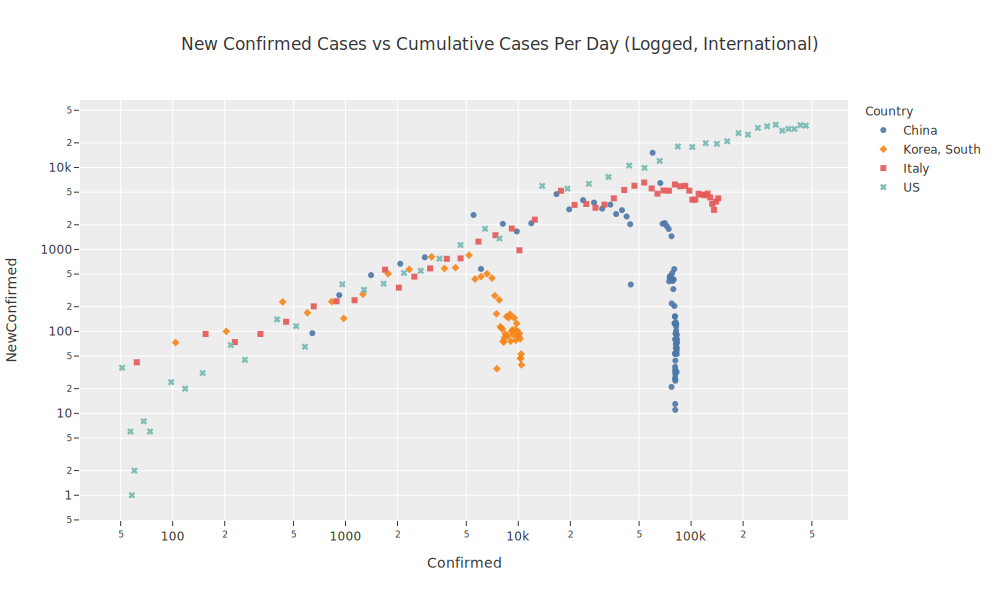

In [30]:
# Appears that China and South Korea have defintely been able to "flatten" the curve, while Italy is nearing the end of the tunnel. 
countriesToPlot = ['US', 'Korea, South', 'Italy', 'China']
fig =   px.scatter(data_frame=df_country[df_country.Country.isin(countriesToPlot)].loc[df_country.Confirmed > 50], 
                   x='Confirmed', y='NewConfirmed', color='Country', symbol='Country',
                   log_x=True,log_y=True, 
                   hover_name='Date', hover_data=['NewConfirmed','Confirmed','Date','EpidemicStartDate'],
                   title='New Confirmed Cases vs Cumulative Cases Per Day (Logged, International)', template='ggplot2', 
                   color_discrete_sequence= px.colors.qualitative.T10, opacity=0.9
                  )
fig.show(width=1000, height=600,
         renderer='svg'
        )

In [23]:
# To Do: Animated scatter against date

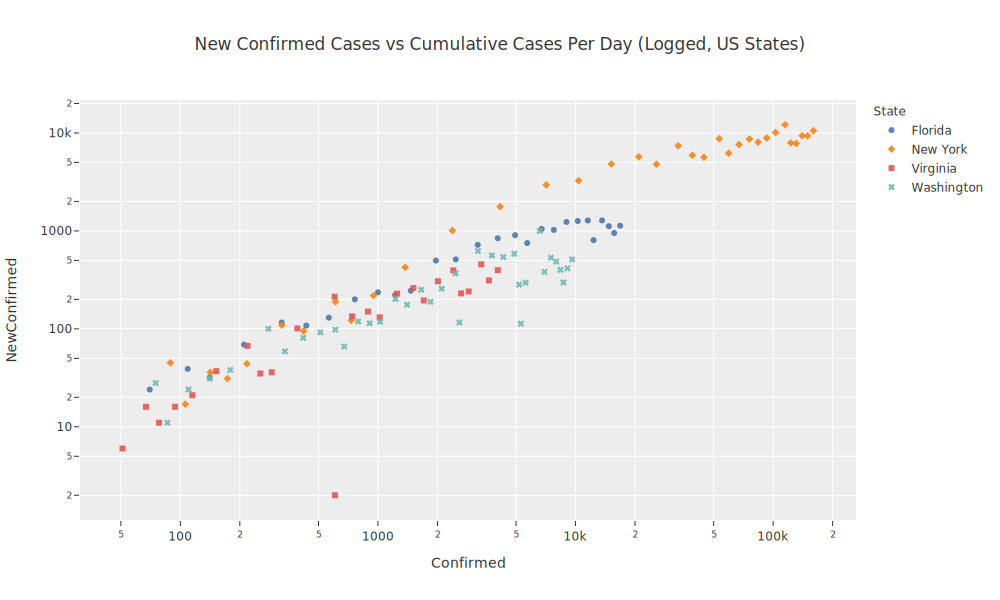

In [31]:
# Conducting a similar analysis applied towards US states:
statesToPlot = ['New York', 'Washington', 'Lousiana', 'Virginia', 'Florida']
fig =   px.scatter(data_frame=df_state[df_state.State.isin(statesToPlot)].loc[df_state.Confirmed>50], 
                   x='Confirmed', y='NewConfirmed', color='State', symbol='State',
                   log_x=True,log_y=True, labels={'y':'Daily New Cases', 'x':'Cumulative Confirmed Cases'},
                   hover_name='Date', hover_data=['State','DaysElapsed','Date','EpidemicStartDate'],
                   title='New Confirmed Cases vs Cumulative Cases Per Day (Logged, US States)', template='ggplot2', 
                   color_discrete_sequence= px.colors.qualitative.T10, opacity=0.9
#                    color_continuous_scale='Teal_r', 
                  )
# Add smoothed lines
fig.update(layout_coloraxis_showscale=False)
fig.show(width=1000, height=600,
         renderer='svg'
        )

## Some time series plots

### Confirmed cases in US States with governor lockdown measures 
Containment is a critical measure in reducing effective reproductive number of the virus. Most early-stage growth models can be viewed as a piecewise composition of a basic reproduction number ($R_0$) and a second effective reproduction number($R_e$). A team at the University of Toronto has a great article and corresponding dashboard explaining this concept: https://annals.org/aim/fullarticle/2760912/reporting-epidemic-growth-reproduction-numbers-2019-novel-coronavirus-2019-ncov. 
US states have undergone containment measures in different timelines. Assuming a delay comprised of a biological incubation, delay for testing & recording, we can expect to see tangible changes to ($R_e$) roughly two weeks post.

New Jersey entered containment on 2020-03-22
New York entered containment on 2020-03-23
Virginia entered containment on 2020-03-30
Washington entered containment on 2020-03-23


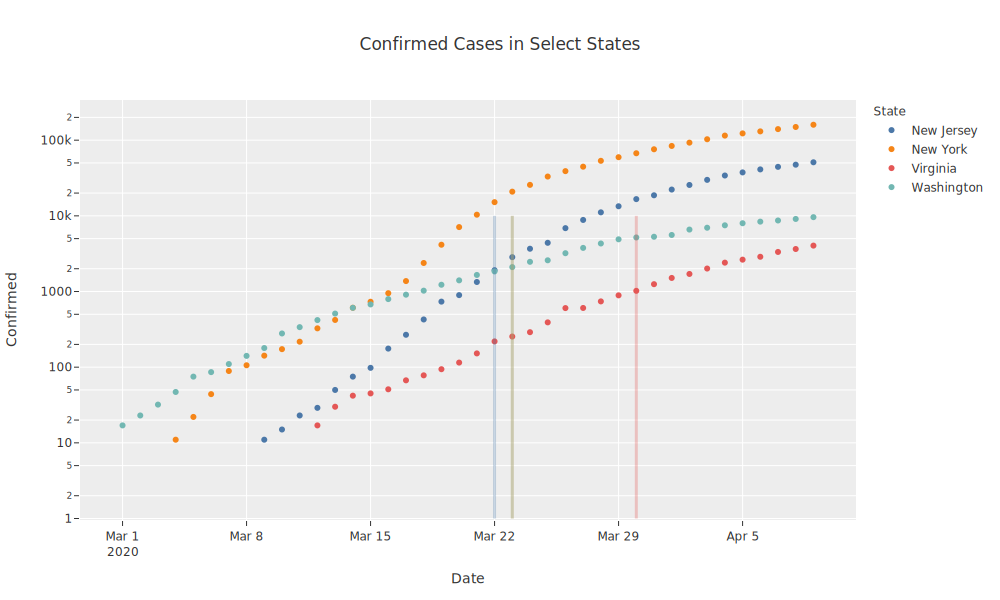

In [25]:
states = ['New York', 'New Jersey', 'Washington', 'Virginia']
fig =px.scatter(data_frame=df_state[df_state.State.isin(states)].loc[df_state.Confirmed > 10], 
                x='Date', y='Confirmed', color='State',
                log_x=False,log_y=True, labels={'y':'Daily New Cases', 'x':'Cumulative Confirmed Cases'},
                hover_name='Date', hover_data=['NewConfirmed','Confirmed','DaysElapsed'],
                title='Confirmed Cases in Select States', template='ggplot2', 
                color_discrete_sequence=px.colors.qualitative.T10,
               )

c = 0
for s in sorted(states):
    containment_date = containment[containment.State==s].Date.values[0]
    fig.add_shape(dict(type="line", 
                       x0=containment_date, y0=1, x1=containment_date, y1=10000, 
                       line=dict(color=px.colors.qualitative.T10[c],
                                 width=3, dash='solid'
                                )))
    c += 1
    print('{} entered containment on {}'.format(s, containment_date))
    
fig.update_shapes(dict(xref='x', yref='y'))

fig.show(width=1000, height=600,
         renderer='svg'
        )

## Testing, testing, testing 

### Tests vs. Cases
As seen in the Wall Street Journal: https://www.wsj.com/articles/how-the-cdcs-restrictive-testing-guidelines-hid-the-coronavirus-epidemic-11584882001.


In [15]:
df_testing.sort_values(by='Date').groupby(['State']).agg('last').reset_index().sample(3)

,State,Date,Positive,Negative,Pending,HospitalizedCurrently,HospitalizedCumulative,InIcuCurrently,InIcuCumulative,OnVentilatorCurrently,OnVentilatorCumulative,Recovered,Death,Hospitalized,Total,TotalTestResults,PosNeg,DeathIncrease,HospitalizedIncrease,NegativeIncrease,PositiveIncrease,TotalTestResultsIncrease
9,DE,2020-04-09,1207.0,8683.0,32.0,201.0,NaN,NaN,NaN,NaN,NaN,173.0,23.0,NaN,9890,9890,9890,7.0,0.0,1055.0,279.0,1334.0
19,KY,2020-04-09,1346.0,20455.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,NaN,21801,21801,21801,8.0,0.0,0.0,197.0,197.0
29,MT,2020-04-09,354.0,7506.0,57.0,13.0,36.0,NaN,NaN,NaN,NaN,157.0,6.0,36.0,7860,7860,7860,0.0,5.0,440.0,22.0,462.0


In [16]:
df_testing.loc[df_testing.State.isin(['NY'])].tail(3)

,State,Date,Positive,Negative,Pending,HospitalizedCurrently,HospitalizedCumulative,InIcuCurrently,InIcuCumulative,OnVentilatorCurrently,OnVentilatorCumulative,Recovered,Death,Hospitalized,Total,TotalTestResults,PosNeg,DeathIncrease,HospitalizedIncrease,NegativeIncrease,PositiveIncrease,TotalTestResultsIncrease
1312,NY,2020-04-07,138863.0,201195.0,NaN,17493.0,32083.0,4593.0,NaN,NaN,NaN,14590.0,5489.0,32083.0,340058,340058,340058,731.0,1880.0,11073.0,8174.0,19247.0
1313,NY,2020-04-08,149316.0,215837.0,NaN,18079.0,32669.0,4593.0,NaN,NaN,NaN,14590.0,6268.0,32669.0,365153,365153,365153,779.0,586.0,14642.0,10453.0,25095.0
1314,NY,2020-04-09,159937.0,231612.0,NaN,18279.0,32869.0,4925.0,NaN,NaN,NaN,14590.0,7067.0,32869.0,391549,391549,391549,799.0,200.0,15775.0,10621.0,26396.0


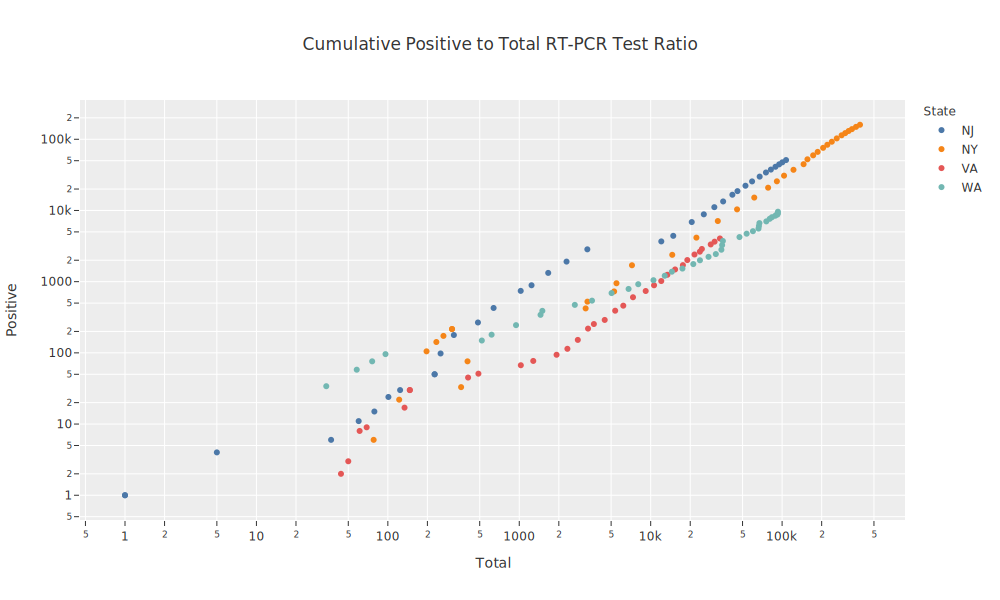

In [26]:
states = ['NY', 'NJ', 'WA', 'VA']
fig = px.scatter(data_frame=df_testing.loc[df_testing.State.isin(states)].loc[df_testing.Date > pd.to_datetime('2020-03-01')],
                 x='Total', y='Positive', color='State',
                 color_discrete_sequence=px.colors.qualitative.T10,
                 log_x=True, log_y=True,                 
                 title='Cumulative Positive to Total RT-PCR Test Ratio',
                 hover_name='Date', hover_data=['Positive','Total', 'Negative', 'State'],
                 template='ggplot2', 
                )
fig.show(width=1000, height=600,
         renderer='svg'
        )

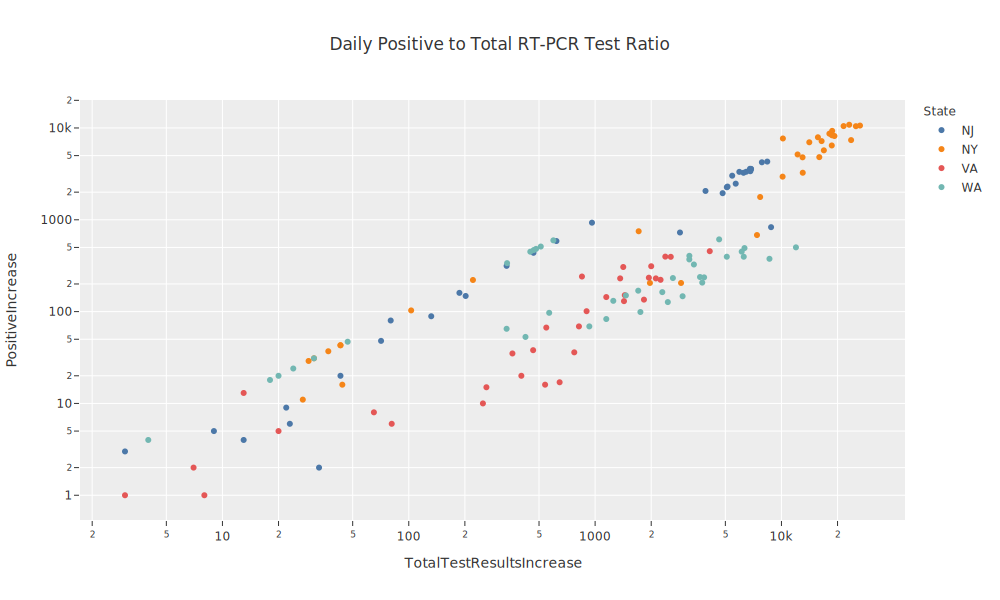

In [32]:
states = ['NY', 'NJ', 'WA', 'VA']
fig = px.scatter(data_frame=df_testing.loc[df_testing.State.isin(states)].loc[df_testing.Date > pd.to_datetime('2020-03-01')],
                 x='TotalTestResultsIncrease', y='PositiveIncrease', color='State',
                 color_discrete_sequence=px.colors.qualitative.T10,
                 log_x=True, log_y=True,                 
                 title='Daily Positive to Total RT-PCR Test Ratio',
                 hover_name='Date', hover_data=['Positive','Total', 'Negative', 'State'],
                 template='ggplot2', 
                )
fig.show(width=1000, height=600,
         renderer='svg'
        )

In [19]:
# fig = px.scatter(data_frame=df_testing.sort_values(by='Date').groupby(['State']).agg('last').reset_index(),
#                  x='Positive', y='Total', color='State', 
#                  log_x=False, log_y=False, template='ggplot2',
#                 )
# fig.show()

# ## Animate this over time

## Hospitalizations & Burden on Healthcare

In [20]:
"""
# Adapted from https://www.kaggle.com/hrmello/us-health-care-system-dive-into-ny
icu_facilities = pd.read_csv("/kaggle/input/uncover/hifld/hifld/urgent-care-facilities.csv")
us_census = pd.read_csv("../input/us-census-demographic-data/acs2017_county_data.csv")
state_abbr = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")


icus_per_state = pd.DataFrame(icu_facilities.groupby(["state"])["id"].nunique()).reset_index()

us_census = us_census.merge(states_abbr, on = "State")
us_census = us_census.rename(columns = {"State": "fullState", "Abbreviation": "state"})

popState = us_census.groupby("state")["TotalPop"].sum().reset_index()

icupopdf = icus_per_state.merge(popState, on = "state")
icupopdf["ICUPopRatio"] = icupopdf["id"]/icupopdf["TotalPop"] * 100000
"""

'\n# Adapted from https://www.kaggle.com/hrmello/us-health-care-system-dive-into-ny\nicu_facilities = pd.read_csv("/kaggle/input/uncover/hifld/hifld/urgent-care-facilities.csv")\nus_census = pd.read_csv("../input/us-census-demographic-data/acs2017_county_data.csv")\nstate_abbr = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")\n\n\nicus_per_state = pd.DataFrame(icu_facilities.groupby(["state"])["id"].nunique()).reset_index()\n\nus_census = us_census.merge(states_abbr, on = "State")\nus_census = us_census.rename(columns = {"State": "fullState", "Abbreviation": "state"})\n\npopState = us_census.groupby("state")["TotalPop"].sum().reset_index()\n\nicupopdf = icus_per_state.merge(popState, on = "state")\nicupopdf["ICUPopRatio"] = icupopdf["id"]/icupopdf["TotalPop"] * 100000\n'

## Geographic distribution of cases

In [21]:
# px.choropleth(data_frame=df_country[df_country.Country.isin(['US', 'Korea, South', 'Italy'])],
#               lat='Lat', lon='Long',
#              )